## Step 1: Put all libraries and packages at top

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for updating the custom imports
%load_ext autoreload
%autoreload 2

### Built-in imports

In [ ]:
# built-in imports
import os
import sys
import time
import random

### Standard imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# working with images
import cv2
import imageio as iio

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
import torchvision
import torchvision.transforms as transforms

# torchsummary
import torchsummary

# interactive progress bar
from tqdm import notebook

from IPython.display import clear_output

In [ ]:
!pip install ipdb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00


### Custom imports

In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main')

# losses
from utils.metrics import iou_pytorch_eval, IoUBCELoss
#from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

# transforms
from utils.transforms import SIZE, resize_transform, train_transforms, test_transforms

sys.path.insert(0, '/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/notebooks')

In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/models')

# models
from models.unet import UNet, UNet_attention

sys.path.insert(0, '/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [ ]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
DEVICE_TYPE_STR = "cuda" if torch.cuda.is_available() else "cpu" # select device for training, i.e. gpu or cpu
DEVICE_STR = f"{DEVICE_TYPE_STR}:3"
print(DEVICE_STR)

cuda:3


## Step 3: Evaluate validation performance (quantitative, full sized images)

### Load model

In [ ]:
#%ls ../checkpoints
!dir /content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/checkpoints


README.md			     UNet_IoUBCELoss_baseline.pth
UNet_BCEWithLogitsLoss_baseline.pth  UNet_IoULoss_baseline.pth


In [ ]:
#model_name = 'UNet_BBIoULoss_baseline'
model_name = 'UNet_IoUBCELoss_baseline'
#model_name = 'UNet_IoULoss_baseline'
# model_name = 'UNet_BCEWithLogitsLoss_baseline'

# model_name = 'UNet_IoULoss_augmented'
# model_name = 'UNet_BCEWithLogitsLoss_augmented'
# model_name = 'UNet_IoUBCELoss_augmented'

### Print info and Plot learning curves:

UNet_IoUBCELoss_baseline
Best epoch: 39
Validation IoU: 0.611712634563446


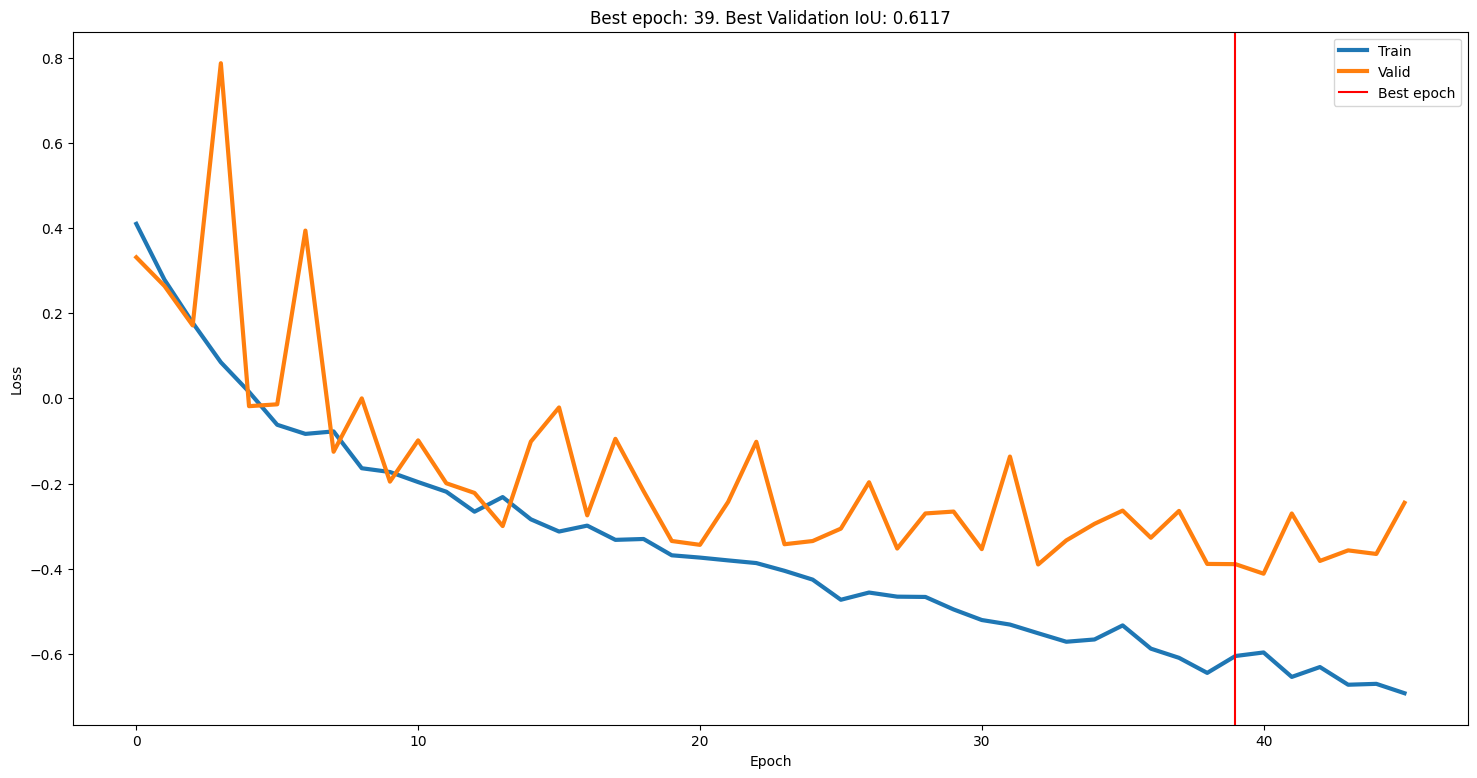

####################################################################################################
UNet_IoULoss_baseline
Best epoch: 30
Validation IoU: 0.5584045648574829


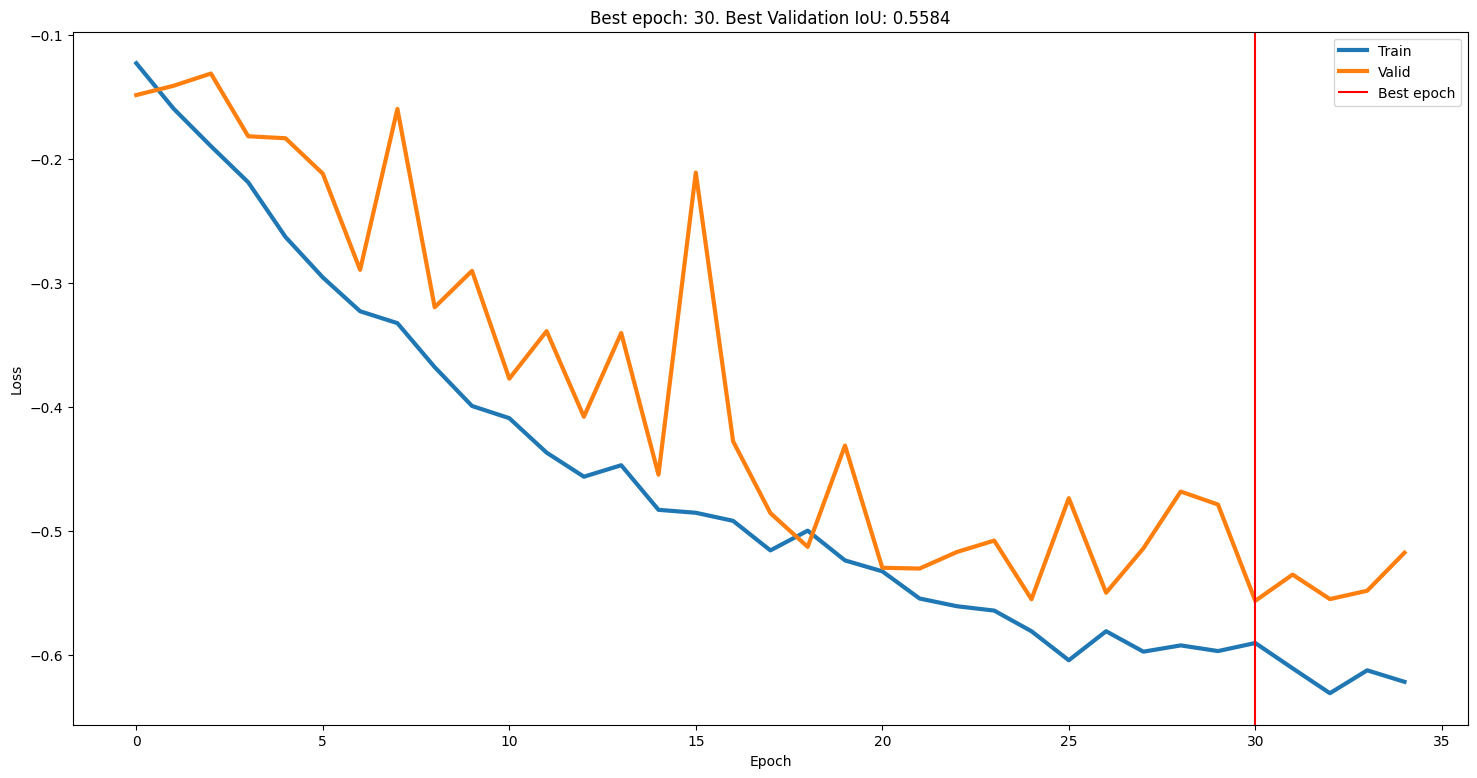

####################################################################################################
UNet_BBIoULoss_baseline


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/checkpoints/UNet_BBIoULoss_baseline.pth'

In [ ]:
for model_name in ['UNet_IoUBCELoss_baseline', 'UNet_IoULoss_baseline', 'UNet_BBIoULoss_baseline',  'UNet_BCEWithLogitsLoss_baseline',  'UNet_IoULoss_augmented', 'UNet_BCEWithLogitsLoss_augmented', 'UNet_IoUBCELoss_augmented']:
    print(model_name)
    history = torch.load(f'/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/checkpoints/{model_name}.pth')

    best_epoch = history['epoch']
    best_iou = history['iou'].item()

    print('Best epoch:', best_epoch)
    print(f'Validation IoU:', best_iou)

    train_losses = history['train_losses']
    val_losses = history['val_losses']

    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train', linewidth=3)
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid', linewidth=3)
    plt.axvline(x=best_epoch, label='Best epoch', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Best epoch: {best_epoch}. Best Validation IoU: {best_iou:.4}')
    plt.legend(loc='best')

    plt.savefig(f"/content/drive/MyDrive/BBIoULoss_Updated_V3/kvasir-seg-main/figures/learning_curves/{model_name}.svg")
    plt.show()

    print('#'*100)

In [ ]:
model_name = "UNet_IoUBCELoss_augmented"

# Uncomment the code in the next cell if want to make predictions on the validation set

# instansiate the model
if model_name == 'UNet_IoULoss_attention':
    model = UNet_attention(channel_in=3, channel_out=1)
else:
    model = UNet(channel_in=3, channel_out=1)

 # load model to DEVICE
model = model.to(DEVICE_STR)

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/{model_name}.pth')['net'])

NameError: name 'UNet' is not defined

### Produce predictions on Validation Set

In [ ]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"

with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]

print(SIZE)
print(resize_transform)

In [ ]:
%mkdir ../predictions_val

In [ ]:
PRED_PATH = '../predictions_val'
time_taken = []
ious = []
metrics = {}

model.eval() # enter inference/evaluation mode
for name in notebook.tqdm(ids_val):
    metrics[name] = {} # to record metrics for this particular image
    path_img = os.path.join(path_images, name)
    path_mask = os.path.join(path_masks, name)

    img = iio.v3.imread(path_img) / 255
    mask = iio.v3.imread(path_mask)[:, :, 0] / 255
    mask = mask.round() # binarize to 0 or 1

    # record shape to revert to
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)

    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0)
    mask_binary = torch.FloatTensor(mask).unsqueeze(0)

    # resize for the model
    img, mask = resize_transform(img), resize_transform(mask_binary)

    # put on the GPU
    img, mask = img.to(DEVICE_STR), mask.to(DEVICE_STR)

    # we do not need to calculate gradients
    with torch.no_grad():
        # Start time
        start_time = time.time()
        ## Prediction
        pred = model(img)
        # End timer
        end_time = time.time() - start_time

    time_taken.append(end_time)
    #print("{} - {:.10f}".format(name, end_time))


    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
    # remove channel => BATCH x H x W
    pred = pred.squeeze(0)


    # sigmoid, threshold, record score
    ious.append(iou_pytorch_test(pred, mask_binary).item())

    metrics[name]['Jaccard'] = iou_pytorch_test(pred, mask_binary).item()
    metrics[name]['DSC'] = dice_pytorch_test(pred, mask_binary).item()
    metrics[name]['Recall'] = recall_pytorch_test(pred, mask_binary).item()
    metrics[name]['Precision'] = precision_pytorch_test(pred, mask_binary).item()
    metrics[name]['F2'] = fbeta_pytorch_test(pred, mask_binary, beta=2.).item()
    metrics[name]['Accuracy'] = accuracy_pytorch_test(pred, mask_binary, ).item()

    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nmean time taken: ", mean_time_taken)
print("Mean FPS: ", mean_fps)

mean_iou = np.mean(ious)
print("\nMean IoU: ", mean_iou)

In [ ]:
metrics_df = pd.DataFrame(metrics).T.round(5)
metrics_df = metrics_df[['Jaccard', 'DSC', 'Recall', 'Precision', 'Accuracy', 'F2']]
metrics_df = metrics_df.sort_values('Jaccard', ascending=False)
metrics_df

### Mean Scores

In [ ]:
metrics_df.mean(axis=0)

In [ ]:
# for LaTeX table
' & '.join(list(metrics_df.mean(axis=0).round(4).values.astype(str)))

## Step 5: Evaluate validation performance (visial, full sized images)

### Best cases

In [ ]:
list(metrics_df.head().index)

In [ ]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(metrics_df.head().index):

    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = iio.v3.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')

    plt.subplot(3,5,i+6)
    mask = iio.v3.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')

    plt.subplot(3,5,i+11)
    pred = iio.v3.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')

    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')


plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
plt.show()

### Worst cases

In [ ]:
list(metrics_df.tail().index)

In [ ]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(metrics_df.tail().index):

    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = iio.v3.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')

    plt.subplot(3,5,i+6)
    mask = iio.v3.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')

    plt.subplot(3,5,i+11)
    pred = iio.v3.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')

    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')


plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
plt.show()

### Different cases

In [ ]:
#plt.figure(figsize=(15, 5))
for i, name in enumerate(metrics_df.index):
    print(name)
    plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 2))

    plt.subplot(1,3,1)
    img = iio.v3.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    if i == 0:
        plt.xlabel('Image')

    plt.subplot(1,3,2)
    mask = iio.v3.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.xlabel('Truth')

    plt.subplot(1,3,3)
    pred = iio.v3.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.xlabel('Prediction')


    plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
    plt.show()

    print(80 * '-', '\n')

- fat: cju16ach3m1da0993r1dq3sn2.jpg
- medium: cju85rkbnlo1c08503uxcpax1.jpg
- small: cju8ceacrsqkr0755hdz145es.jpg
- very small: cjyzuio1qgh040763k56deohv.jpg
- flat: cjyzkpsbjdsjq07211dfi4sru.jpg

In [ ]:
different_polyp_names = ['cju16ach3m1da0993r1dq3sn2.jpg', 'cju85rkbnlo1c08503uxcpax1.jpg', 'cju8ceacrsqkr0755hdz145es.jpg', 'cjyzuio1qgh040763k56deohv.jpg', 'cjyzkpsbjdsjq07211dfi4sru.jpg']

In [ ]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(different_polyp_names):

    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = iio.v3.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')

    plt.subplot(3,5,i+6)
    mask = iio.v3.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')

    plt.subplot(3,5,i+11)
    pred = iio.v3.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')

    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')

plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
#plt.savefig('../figures/validation_examples/different_polyps_img_mask_pred.svg')
plt.show()